# Multi node tests
### [1.Modules](#Modules)  
### [2.parameters](#parameters)   
### [3.Scenario](#Scenario-(WRR-수정*))
### [4.Delay](#Delay-분석)
### [5.WRR](#Weighted-round-robin-to-find-optimal-weight)

In [2]:
import sys
sys.path.append('/Users/jihye/src/Ryu project/TSN-with-DQN/ddqn')

import pandas as pd
import simpy
# from node import Node
import time
import tensorflow as tf
# from parameter import *
# from src import Src

## Modules
**Copy classes(Node(),Src()) manualy instead of importing due to Global parameter**

In [3]:

class Node:

    def __init__(self, node, env, start):
        self.node = node
        self.env = env
        self.start = start
        self.output_port = [[simpy.Store(env), simpy.Store(env)] for _ in range(OUTPUT_PORT)]
        # self.trans_queue = simpy.Store(env)
        self.action = [number_to_action(INITIAL_ACTION) for _ in range(OUTPUT_PORT)]
        self.port = -1
        self.r = [0, 0]
        self.rr = 0
        self.state = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]

    def reset(self, env, start):  # initial state, new episode start
        self.env = env
        self.start = start
        self.r = [0, 0]
        self.rr = 0
        self.output_port = [[simpy.Store(env), simpy.Store(env)] for _ in range(OUTPUT_PORT)]
        self.action = [number_to_action(INITIAL_ACTION) for _ in range(OUTPUT_PORT)]
        self.state = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]
        self.port = -1

    def schedulable(self):
        port = []

        for p in range(OUTPUT_PORT):
            q1 = int(self.state[p][0])
            q2 = int(self.state[p][2])
            # print (q1, q2)
            if not (q1 + q2 == (q1 or q2)):
                port.append(p)

        return port

    def link(self, output, scheduler='sp'):
        if scheduler == 'ddqn':
            for p in range(OUTPUT_PORT):
                yield self.env.process(self.ddqn_with_heuristic(output, p))
        elif scheduler == 'sp':
            for p in range(OUTPUT_PORT):
                yield self.env.process(self.strict_priority(output, p))
        elif scheduler == 'rr':
            for p in range(OUTPUT_PORT):
                yield self.env.process(self.round_robin(output, p))
        else:
            for p in range(OUTPUT_PORT):
                yield self.env.process(self.ddqn(output, p))

    def packet_in(self, pk):
        pt = 0
        if OUTPUT_PORT == 2:
            if self.port == -1:
                if pk.route_[1]:
                    self.port = pk.route_[1]
                else:
                    self.port = 0
            else:
                if self.port:
                    if not (pk.route_[1] == self.port):
                        pt = 1
        yield self.output_port[pt][pk.priority_ - 1].put(pk)

    def step(self):

        for p in range(OUTPUT_PORT):
            qlen, max_et = self.queue_info(p)
            state = np.zeros((PRIORITY_QUEUE, STATE))
            state[:, 0] = qlen
            state[:, 1] = max_et
            self.state[p] = state.flatten()

        return self.state

    def queue_info(self, port):
        l = [0, 0]  # state 1
        pod = [[], []]
        max_et = [0, 0]  # state 2
        for q in range(PRIORITY_QUEUE):
            flows = self.output_port[port][q].items
            if not flows:
                continue
            l[q] += len(flows)
            for i, flow in enumerate(flows):
                # The unit of estimated delay is T(timeslot)
                if SINGLE_NODE:
                    # et = flow.current_delay_ + flow.queueing_delay_ + flow.remain_hops_ + i
                    et = (flow.random_delay_ + flow.current_delay_ + flow.queueing_delay_ + flow.remain_hops_ + i)
                else:
                    # et = sum(flow.queueing_delay_) + flow.remain_hops_ + i
                    et = (flow.random_delay_ + sum(flow.queueing_delay_) + flow.remain_hops_ + i)
                pod_ = round(et/flow.deadline_,2)
                pod[q].append(pod_)
            max_et[q] = max(pod[q])
        return l, max_et

    def action_update(self, action, port):  # observe state and update GCL (cycle : 0.2*3)
        self.action[port] = number_to_action(action)

    def delay_for_packet_multinode(self, port):
        for q in range(PRIORITY_QUEUE):
            waiting = self.output_port[port][q].items
            for w in waiting:
                r = w.remain_hops_
                l = len(w.queueing_delay_)
                w.queueing_delay_[l - r - 1] += 1

    def delay_for_packet(self, port):
        for q in range(PRIORITY_QUEUE):
            waiting = self.output_port[port][q].items
            for w in waiting:
                w.queueing_delay_ += 1

    def ddqn_with_heuristic(self, output, port):

        priority1 = self.output_port[port][0].items
        priority2 = self.output_port[port][1].items

        if not priority1:
            # print("priority1 없음 - work conserving")
            if len(self.output_port[port][1].items):
                # print("priority2 보냄")
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                # if (port == 0) and (self.node == 2):
                #     print((self.env.now- self.start), "H - p2", fl.generated_time_, fl.queueing_delay_, fl.current_delay_)
                yield output.put(fl)

        elif not priority2:
            if len(self.output_port[port][0].items):
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                # if (port == 0) and (self.node == 2):
                #     print((self.env.now- self.start), "H - p1", fl.generated_time_, fl.queueing_delay_, fl.current_delay_)
                yield output.put(fl)
        else:
            if action_to_number(self.action[port]) == 0:
                # if len(self.output_port[port][0].items):
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                # if (port == 0) and (self.node == 2):
                #     print((self.env.now- self.start), "Q - p1", fl.generated_time_, fl.queueing_delay_, fl.current_delay_)
                yield output.put(fl)

            else:
                # if len(self.output_port[port][1].items):
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                # if (port == 0) and (self.node == 2):
                #     print((self.env.now- self.start), "Q - p2", fl.generated_time_, fl.queueing_delay_, fl.current_delay_)
                yield output.put(fl)

        if SINGLE_NODE:
            self.delay_for_packet(port)
        else:
            self.delay_for_packet_multinode(port)

    def ddqn(self, output, port):

        if action_to_number(self.action[port]) == 0:
            if len(self.output_port[port][0].items):
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)

        else:
            if len(self.output_port[port][1].items):
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)

        if SINGLE_NODE:
            self.delay_for_packet(port)
        else:
            self.delay_for_packet_multinode(port)

    def round_robin(self, output, port):

        priority1 = self.output_port[port][0].items
        priority2 = self.output_port[port][1].items

        # n = [1, 0]
        if not priority1: #work-conserving regardless of weight
            if len(self.output_port[port][1].items):
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)

        elif not priority2: #work-conserving regardless of weight
            if len(self.output_port[port][0].items):
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)
                
        else: #scheduling
            if self.r[1] == 1:
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                self.r = [0, 0]
                yield output.put(fl)
            
            elif self.r[0] < RRW:
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)
                if self.r[0] == RRW - 1:
                    self.r[1] = 1
                else:
                    self.r[0] += 1
                    
        if SINGLE_NODE:
            self.delay_for_packet(port)
        else:
            self.delay_for_packet_multinode(port)

    def strict_priority(self, output, port):

        for q in range(PRIORITY_QUEUE):
            if len(self.output_port[port][q].items):
                fl = yield self.output_port[port][q].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)
                break

        if SINGLE_NODE:
            self.delay_for_packet(port)
        else:
            self.delay_for_packet_multinode(port)


In [4]:

class Src:
    def __init__(self, src, start_time, seq):
        self.src = src
        self.cnt = 0
        self.episode_start_time = start_time
        self.sequence_p1, self.sequence_p2 = seq

    def reset(self, src, start_time):
        self.src = src
        self.cnt = 0
        self.episode_start_time = start_time

    def flow_generator(self, now, src, fnum):
        flow = Flow()

        flow.priority_ = 1

        if 1 < src < 8:  # must got to be editted when network topology being changed
            flow.priority_ = 2

        flow.src_ = src
        flow.dst_ = src
        flow.num_ = fnum
        flow.generated_time_ = now - self.episode_start_time
        flow.current_delay_ = 0
        flow.met_ = -1

        if SINGLE_NODE:
            flow.route_ = []
            flow.queueing_delay_ = 0

            if flow.priority_ == 1:
                flow.remain_hops_ = self.sequence_p1[1][fnum]
                flow.random_delay_ = self.sequence_p1[0][fnum]
                flow.deadline_ = CC_DEADLINE
                flow.bits_ = CC_BYTE * 8
            else:
                flow.remain_hops_ = self.sequence_p2[1][fnum]
                flow.random_delay_ = self.sequence_p2[0][fnum]
                flow.deadline_ = BE_DEADLINE
                flow.bits_ = BE_BYTE * 8

        else:
            flow.route_ = route[src - 1]
            h = len(route[src - 1]) - 1
            flow.remain_hops_ = h - 1
            flow.queueing_delay_ = [0 for _ in range(h)]  # nodes to be passed packts

            if flow.priority_ == 1:
                flow.deadline_ = CC_DEADLINE
                flow.random_delay_ = self.sequence_p1[0][fnum]
                flow.bits_ = CC_BYTE * 8

            else:
                flow.deadline_ = BE_DEADLINE
                flow.random_delay_ = self.sequence_p2[0][fnum]
                flow.bits_ = BE_BYTE * 8

        return flow

    def send(self, env, nodes, src):
        if SINGLE_NODE:
            if not 1 < src < 8:  # must got to be editted when network topology being changed
                for i in range(COMMAND_CONTROL):
                    flow = self.flow_generator(env.now, src, i)
                    yield env.process(nodes.packet_in(flow))
                    yield env.timeout(TIMESLOT_SIZE * PERIOD_CC / 1000)

            else:
                for i in range(BEST_EFFORT):
                    flow = self.flow_generator(env.now, src, i)
                    yield env.process(nodes.packet_in(flow))
                    yield env.timeout(TIMESLOT_SIZE * PERIOD_BE / 1000)
        else:
            if not 1 < src < 8:  # must got to be editted when network topology being changed
                for i in range(COMMAND_CONTROL):
                    flow = self.flow_generator(env.now, src, i)
                    r = flow.route_[0]
                    yield env.process(nodes[r - 1].packet_in(flow))
                    yield env.timeout(TIMESLOT_SIZE * PERIOD_CC / 1000)

            else:
                for i in range(BEST_EFFORT):
                    flow = self.flow_generator(env.now, src, i)
                    r = flow.route_[0]
                    yield env.process(nodes[r - 1].packet_in(flow))
                    yield env.timeout(TIMESLOT_SIZE * PERIOD_BE / 1000)


In [5]:
class Node_Old(Node):
    def __init__(self,node,env,start):
        super().__init__(node,env,start)
        
    def queue_info(self, port):
        l = [0, 0]  # state 1
        pod = [[], []]
        max_et = [0, 0]  # state 2
        for q in range(PRIORITY_QUEUE):
            flows = self.output_port[port][q].items
            if not flows:
                continue
            l[q] += len(flows)
            for i, flow in enumerate(flows):
                # The unit of estimated delay is T(timeslot)
                if SINGLE_NODE:
                    # et = flow.current_delay_ + flow.queueing_delay_ + flow.remain_hops_ + i
                    et = (flow.random_delay_ + flow.current_delay_ + flow.queueing_delay_ + flow.remain_hops_ + i)
                else:
                    # et = sum(flow.queueing_delay_) + flow.remain_hops_ + i
                    et = (flow.random_delay_ + sum(flow.queueing_delay_) + flow.remain_hops_ + i)
#                 pod_ = round(et/flow.deadline_,2)
                pod[q].append(et)
            max_et[q] = max(pod[q])
        return l, max_et
        

In [16]:

def operator(delay):
    delay = np.mean(delay * 1000)
    return delay


class GateControlTestSimulation:

    def __init__(self):
        self.model = tf.keras.models.load_model(WEIGHT_FILE)
        self.env = simpy.Environment()
        self.start_time = self.env.now
        self.nodes = [Node_Old(n + 1, self.env, self.start_time) for n in range(NODES)]
        self.output = {1: simpy.Store(self.env),
                       2: simpy.Store(self.env),
                       3: simpy.Store(self.env),
                       4: simpy.Store(self.env),
                       5: simpy.Store(self.env),
                       6: simpy.Store(self.env),
                       7: simpy.Store(self.env),
                       8: simpy.Store(self.env),
                       9: simpy.Store(self.env)}
        self.seq = random_sequence()
        self.source = Src(1, self.start_time, self.seq)
        self.timeslots = 0
        state_shape = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]
        self.state = [state_shape for _ in range(NODES)]
        self.reward = [0 for _ in range(NODES)]
        self.next_state = [state_shape for _ in range(NODES)]
        self.done = False
        self.end_time = 0
        self.received_packet = 0
        self.score = 0

        self.avg_delay = [[], []]
        self.qdelay = [[], []]
        self.estimated_e2e = [[], []]
        self.success = [0 for _ in range(SRCES)]
        self.scenario = pd.DataFrame(columns = ['type','Score','p1','p2'])

        # self.state_and_action = []

    def reset(self):  # initial state, new episode start
#         self.env = simpy.Environment()
        self.start_time = self.env.now  # episode 시작
        self.nodes = [Node_Old(n + 1, self.env, self.start_time) for n in range(NODES)]
        self.source = Src(1, self.start_time, self.seq)
        self.timeslots = 0
        self.output = {1: simpy.Store(self.env),
                       2: simpy.Store(self.env),
                       3: simpy.Store(self.env),
                       4: simpy.Store(self.env),
                       5: simpy.Store(self.env),
                       6: simpy.Store(self.env),
                       7: simpy.Store(self.env),
                       8: simpy.Store(self.env),
                       9: simpy.Store(self.env)}
        state_shape = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]
        self.state = [state_shape for _ in range(NODES)]
        self.next_state = [state_shape for _ in range(NODES)]
        self.reward = [0 for _ in range(NODES)]
        self.done = False
        self.end_time = 0
        self.received_packet = 0
        self.success = [0 for _ in range(SRCES)]
        self.avg_delay = [[], []]
        self.qdelay = [[], []]
        self.score = 0
        
    def ddqn_predict(self, state):
        n = self.model.predict(state)
        id_ = np.argmax(n)
        # print (id_)
        # action = number_to_action(id_)
        return id_

    def sendTo_next_node(self, env, output):

        for i, pkts in output.items():
            if not len(pkts.items):
                continue
            for _ in range(len(pkts.items)):
                node = i - 1
                self.reward[node] += A
                packet = yield pkts.get()
                h = packet.remain_hops_
                l = len(packet.queueing_delay_)
                # print (h, l)
                q = packet.queueing_delay_[l - h - 2]
                packet.current_delay_ += q + 1

                p = packet.priority_ - 1
                src = packet.src_
                # print(packet.current_delay_)
                if packet.remain_hops_ < 0:
                    packet.remain_hops_ = 0
                # ET = packet.current_delay_ + packet.remain_hops
                ET = packet.current_delay_ + packet.remain_hops_ + packet.random_delay_
                
                if ET <= packet.deadline_:
                    self.reward[node] += W[p]
                
                if node == 1 or node == 7:
                    self.qdelay[p].append(q)
                    
                if packet.route_ == [0]:
                    self.received_packet += 1
                    
                    if node == 6 or node == 8:
                        # self.avg_delay[p].append(packet.queueing_delay_)
                        self.avg_delay[p].append(ET*TIMESLOT_SIZE)

                    if ET <= packet.deadline_:
                        packet.met_ = 1
#                         print(ET, self.received_packet)
                        # print (src - 1)
                        self.success[src - 1] += 1
                    else:
                        packet.met_ = 0
                else:
                    r = packet.route_[0]
                    yield env.process(self.nodes[r - 1].packet_in(packet))

    def src_send(self, env):
        if WITH_FLOW :
            env.process(self.source.send(env, self.nodes, 1))
            env.process(self.source.send(env, self.nodes, 2))
            env.process(self.source.send(env, self.nodes, 3))
            env.process(self.source.send(env, self.nodes, 4))
            env.process(self.source.send(env, self.nodes, 5))
            env.process(self.source.send(env, self.nodes, 6))
            env.process(self.source.send(env, self.nodes, 7))
            env.process(self.source.send(env, self.nodes, 8))
        
        else :
            env.process(self.source.send(env, self.nodes, 1))
            env.process(self.source.send(env, self.nodes, 2))
            env.process(self.source.send(env, self.nodes, 7))
            env.process(self.source.send(env, self.nodes, 8))

    def rl_agent(self, env):  # mainprocess
        s = time.time()
        rewards_all = []
        a = [INITIAL_ACTION for _ in range(OUTPUT_PORT)]
        action = [a for _ in range(NODES)]

        self.src_send(self.env)

        while not self.done:
            self.timeslots += 1

            for n in range(NODES):
                yield env.process(self.nodes[n].link(self.output[n + 1], 'ddqn'))
            yield env.process(self.sendTo_next_node(env, self.output))
            yield env.timeout(TIMESLOT_SIZE / 1000)

            for n in range(NODES):
                self.next_state[n] = self.nodes[n].step()
                self.done = self.terminated()
            rewards_all.extend(self.reward)
            self.reward = [0 for _ in range(NODES)]
            self.state = self.next_state

            # observe(생략)

            for n in range(NODES):
                p = self.nodes[n].schedulable()
                # p = [0, 1]
                for i in p:
                    # print("node:", n, self.state[n][i])
                    action[n][i] = self.ddqn_predict(
                        np.array(self.state[n][i]).reshape(1, INPUT_SIZE))
                    self.nodes[n].action_update(action[n][i], i)

        # Episode ends
        self.end_time = env.now
        e = time.time() - s
        self.score = np.sum(rewards_all)
        success1 = self.success[0]+self.success[7]
        success2 = np.sum(self.success[1:7])
        log_ = pd.DataFrame([('ddqn',self.score ,success1, success2)],columns = ['type','Score','p1','p2'])
        self.scenario = self.scenario.append(log_,ignore_index=True)

    def SP(self, env):
        s = time.time()
        rewards_all = []

        self.src_send(self.env)

        while not self.done:  # 1회의 episode가 종료될 때 까지 cycle을 반복하는 MAIN process
            self.timeslots += 1

            for n in range(NODES):
                yield env.process(self.nodes[n].link(self.output[n + 1], 'sp'))
#                 print(al)
            yield env.process(self.sendTo_next_node(env, self.output))
            yield env.timeout(TIMESLOT_SIZE / 1000)

            for n in range(NODES):
                # self.next_state[n] = self.nodes[n].step()
                self.done = self.terminated()
            rewards_all.extend(self.reward)
            self.reward = [0 for _ in range(NODES)]
            # self.state = self.next_state

        e = time.time() - s
        self.score = np.sum(rewards_all)
        success1 = self.success[0]+self.success[7]
        success2 = np.sum(self.success[1:7])
        log_ = pd.DataFrame([('sp',self.score ,success1, success2)],columns = ['type','Score','p1','p2'])
        self.scenario = self.scenario.append(log_,ignore_index=True)
        
    def RR(self, env):
        s = time.time()
        rewards_all = []

        self.src_send(self.env)

        while not self.done:  # 1회의 episode가 종료될 때 까지 cycle을 반복하는 MAIN process
            self.timeslots += 1

            for n in range(NODES):
                yield env.process(self.nodes[n].link(self.output[n + 1], 'rr'))
#                 print(al)
            yield env.process(self.sendTo_next_node(env, self.output))
            yield env.timeout(TIMESLOT_SIZE / 1000)

            for n in range(NODES):
                # self.next_state[n] = self.nodes[n].step()
                self.done = self.terminated()
            rewards_all.extend(self.reward)
            self.reward = [0 for _ in range(NODES)]
            # self.state = self.next_state

        e = time.time() - s
        self.score = np.sum(rewards_all)
        success1 = self.success[0]+self.success[7]
        success2 = np.sum(self.success[1:7])
        log_ = pd.DataFrame([('rr',self.score ,success1, success2)],columns = ['type','Score','p1','p2'])
        self.scenario = self.scenario.append(log_,ignore_index=True)

    def model_simulation(self, i, model='ddqn'):
        if model == 'ddqn':
            self.env.process(self.rl_agent(self.env))
            self.env.run()
            D1 = self.avg_delay[0]
            D2 = self.avg_delay[1]
            d1 = pd.DataFrame(D1)
            d2 = pd.DataFrame(D2)
#             d1.to_csv('./test/delay1.csv')
#             d2.to_csv('./test/delay2.csv')
            if i > 0:
                print("DDQN+H , Final Step: {t}, success: {l}, avg_qdelay: {d}".format(
                    t=self.timeslots,
                    l=self.success,
                    d=list(map(operator, self.avg_delay))))
#                 print("qdelay : ", self.qdelay)

        elif model == 'sp':
            self.env.process(self.SP(self.env))
            self.env.run()

            D1 = self.avg_delay[0]
            D2 = self.avg_delay[1]
            d1 = pd.DataFrame(D1)
            d2 = pd.DataFrame(D2)
#             d1.to_csv('./test/SP/delay1.csv')
#             d2.to_csv('./test/SP/delay2.csv')
            if i > 0:
                print("SP , Final Step: {t}, success: {l}, avg_qdelay: {d}".format(
                    t=self.timeslots,
                    l=self.success,
                    d=list(map(operator, self.avg_delay))))
#                 print("qdelay : ", self.qdelay)
#             self.reset()

        elif model == 'rr':
            self.env.process(self.RR(self.env))
            self.env.run()

            D1 = self.avg_delay[0]
            D2 = self.avg_delay[1]
            d1 = pd.DataFrame(D1)
            d2 = pd.DataFrame(D2)
            d1.to_csv('./test/RR/delay1.csv')
            d2.to_csv('./test/RR/delay2.csv')
            if i > 0:
                print("RR , Final Step: {t}, success: {l}, avg_qdelay: {d}".format(
                    t=self.timeslots,
                    l=self.success,
                    d=list(map(operator, self.avg_delay))))
#                 print("qdelay : ", self.qdelay)

        elif model == 'reset':
            print("reset")
            self.seq = random_sequence()
#             self.source = Src(1, self.start_time, self.seq)
            self.scenario= pd.DataFrame(columns = ['type','Score','p1','p2'])


    def simulation(self):
        iteration = 2
        s1 = 0
        s2 = 0
        for i in range(iteration):
            self.reset()
            self.model_simulation(i, 'sp')
            
            self.reset()
            self.model_simulation(i, 'rr')
#             if i>0:
#                 s1 = self.score
#                 s1s = self.success
            
            self.reset()

            self.model_simulation(i, 'ddqn')
#             if i>0:
#                 s2 = self.score
#                 s2s = self.success
            
#             self.reset()
        
            
            
#             if s2>s1:
#                 return [s1,s1s,s2,s2s]
#             self.scenario.to_csv('./test/multi_scenario1.csv')
            
            self.model_simulation(i, 'reset')
            
#         return 'X'
    
    def terminated(self):
        done = False

        if MAXSLOT_MODE:
            if (self.received_packet == COMMAND_CONTROL * 2 + BEST_EFFORT * 6) or (self.timeslots >= MAXSLOTS):
                done = True
        else:
            if self.received_packet == COMMAND_CONTROL * 2 + BEST_EFFORT * 6:  # originally (CC + A + V + BE)
                done = True

        return done

## parameters

In [7]:
import os
from dataclasses import dataclass
import numpy as np
import random

# parameters
SINGLE_NODE = False  # False
OUTPUT_PORT = 2  # 2
SRCES = 8  # 8
WITH_FLOW = True

# Reward
COMPLEX = False
BOUND = [0.5, 0.6]
W0 = [0.1, 0.03]
W1 = [0.01, 0.01]
W2 = [-0.6, -0.2]
W3 = -1
LM = 1.5
W = [0.6, 0.5]
# W = [0.5, 0.5] #? 왜 이게 더 잘되지
A = 0.01
RRW=3

# HOP_WEIGHT = 4
RANDOM_HOP = 0  # 0
RANDOM_CURRENT_DELAY_CC = 1  # originally 0 unit : T
RANDOM_CURRENT_DELAY_BE = [0, 3]  # originally [0,1] unit : T
PERIOD_CC = 2  # T
PERIOD_BE = 2
COMMAND_CONTROL = 60  # 40
BEST_EFFORT = 60  # 100
CC_DEADLINE = 7  # 5 (8 T), 10 least 5T, unit : T (if not, just multiply TIMESLOT_SIZE)
BE_DEADLINE = 7  # 50 ( 75 T ) 12
FIXED_SEQUENCE = False
FIRST_TRAIN = True
MAXSLOT_MODE = True
MAXSLOTS = 350  # 250
LEARNING_RATE = 0.001  # 0.0001
UPDATE = 400  # 500
EPSILON_DECAY = 0.9998  # 0.9998

# Save
# DATE = '0429_2'
FILENAME = './@0220/@[17259]0.0013820650056004524.h5'  # weight file name
WEIGHT_FILE = FILENAME

# RL agent
PRIORITY_QUEUE = 2
STATE = 2  # for simulation with different utilizations(periods), it has to be editted to 3
INPUT_SIZE = 4
# GCL_LENGTH = 3
OUTPUT_SIZE = 2
ALPHA = 0.1
INITIAL_ACTION = 0
ACTION_LIST = [0, 1]
ACTION_SIZE = len(ACTION_LIST)
BATCH = 64
EPSILON_MAX = 1
EPSILON_MIN = 0.01
DISCOUNT_FACTOR = 0.99

# Environment
MAX_EPISODE = 20000
# CC_PERIOD = 10
# AD_PERIOD = 6
# VD_PERIOD = 8
# BE_PERIOD = 4  # PERIOD는 Utilization을 위해 조절해야 할 듯

CC_BYTE = 1500
# AD_BYTE = 256
# VD_BYTE = 1500
BE_BYTE = 1500
TIMESLOT_SIZE = 0.6
BANDWIDTH = 20000  # bits per msec (20Mbps)
MAX_BURST = 12000
NODES = 9
MAX_REWARD = COMMAND_CONTROL * W[0] + BEST_EFFORT * W[1] + A * (COMMAND_CONTROL + BEST_EFFORT)
print(f'available maximum reward is {MAX_REWARD}')
# random parameters

# W = [10,10,1,0.1]


# if not os.path.exists("./result/" + DATE):
#     os.makedirs("./result/" + DATE)

# f = open("./result/" + DATE + "/parameters.txt", 'w')
# d = "DATE : {p} \n REWARD MODE : {rm} \n MAX_REWARD : {mr} \n \
#     FIXED_SEQUENDE MODE : {f} \n MAX_SLOTS MODE : {ms} \n \
#     LEARNING_RATE: {s} \n MAX_EPISODE: {t} \n DEADLINE : {e} \n \
#     PNUM : {m} \n weight:{w} \n alpha:{a}".format(
#     p=DATE,
#     f=FIXED_SEQUENCE,
#     rm=COMPLEX,
#     mr=MAX_REWARD,
#     ms=MAXSLOT_MODE,
#     s=LEARNING_RATE,
#     t=MAX_EPISODE,
#     e=[CC_DEADLINE, BE_DEADLINE],
#     m=[COMMAND_CONTROL, BEST_EFFORT],
#     w=W,
#     a=A)
# d = "DATE : {p} \nFIXED_SEQUENDE MODE : {f} \nMAX_SLOTS MODE : {ms} \nLEARNING_RATE: {s} \nMAX_EPISODE: {t} \n \
#     EPSILON_DECAY: {e} \nWeight: {m} \nalpha: {l} \n".format(
#     p=DATE,
#     f=FIXED_SEQUENCE,
#     ms=MAXSLOT_MODE,
#     s=LEARNING_RATE,
#     t=MAX_EPISODE,
#     e=EPSILON_DECAY,
#     m=W,
#     l=A)

# f.write(d)
# f.close()
import matplotlib.pyplot as plt


def save_result_plot(df):
    x = range(int(len(df['Episode'])))
    y = df['Score']
    plt.scatter(x, y, s=3)
    plt.savefig("./result/" + DATE + "/sum of reward.png", dpi=300)


# Functions
def max_burst():
    burst = BANDWIDTH * TIMESLOT_SIZE
    print("burst", burst)


def random_sequence():
    p1 = [[], []]
    p2 = [[], []]

    for i in range(COMMAND_CONTROL):
        hop = random.randint(0, RANDOM_HOP) + 1
        late = int(round(RANDOM_HOP / hop, 0))
        if hop == RANDOM_HOP + 1:
            late = 0
        cd = late + random.randint(0, RANDOM_CURRENT_DELAY_CC)
        p1[0].append(cd)
        p1[1].append(hop)

    for i in range(BEST_EFFORT):
        hop = random.randint(0, RANDOM_HOP) + 1
        late = int(round(RANDOM_HOP / hop, 0))
        if hop == RANDOM_HOP + 1:
            late = 0
        cd = late + random.randint(RANDOM_CURRENT_DELAY_BE[0], RANDOM_CURRENT_DELAY_BE[1])
        p2[0].append(cd)
        p2[1].append(hop)

    return p1, p2


# def utilization():
#     f1 = (CC_BYTE * 8) / CC_PERIOD  # bits per ms
#     f2 = (AD_BYTE * 8) / AD_PERIOD
#     f3 = (VD_BYTE * 8) / VD_PERIOD
#     f4 = (BE_BYTE * 8) / BE_PERIOD
#     utilization1 = (f1 + f2 + f3) / BANDWIDTH
#     print("utilization without BE ", round(utilization1, 2))
#     utilization2 = f4 / BANDWIDTH
#     print("utilization of BE ", round(utilization2, 2))


# def util_calculation(u1, u2):
#     cc_period = round(CC_PERIOD / u1, 1)
#     ad_period = round(AD_PERIOD / u1, 1)
#     vd_period = round(VD_PERIOD / u1, 1)
#     be_period = round(BE_PERIOD / u2, 1)
#     return cc_period, ad_period, vd_period, be_period


def action_to_number(action):
    # action_ = action.flatten()
    bin_ = ''
    for a in action:
        bin_ += str(a)
    return ACTION_LIST.index(int(bin_, 2))


def number_to_action(action_id):  # number -> binary gcl code
    b_id = format(ACTION_LIST[action_id], '02b')
    action_ = np.array(list(map(int, b_id)))
    return action_


route_ = [[1], [4, 5, 2], [7, 8, 9, 6, 3],
          [7, 4, 1, 2, 3], [8, 5, 6], [9]]

route = [[1, 2, 5, 6, 9, 0], [3, 2, 5, 4, 7, 0], [4, 1, 2, 0], [4, 7, 8, 0],
         [6, 3, 2, 0], [6, 9, 8, 0], [7, 8, 5, 6, 3, 0], [9, 8, 5, 4, 1, 0]]


# 첫 번째, 마지막 루트만 priority 1

# packet structure

@dataclass
class Flow:
    src_: int = None
    dst_: int = None
    route_: list = None
    type_: int = None
    priority_: int = None
    num_: int = None
    deadline_: float = None
    generated_time_: float = None
    queueing_delay_: list = None
    current_delay_: float = None
    bits_: int = None
    met_: bool = None
    remain_hops_: int = None
    random_delay_: float = None


available maximum reward is 67.2


In [7]:
test = GateControlTestSimulation()
test.simulation()
#./@0220/@[17259]0.0013820650056004524.h5

SP , Final Step: 125, success: [60, 2, 46, 60, 60, 46, 2, 60], avg_qdelay: [3.2800000000000007, 5.67]
RR , Final Step: 126, success: [60, 23, 56, 60, 59, 53, 23, 60], avg_qdelay: [3.4, 4.71]
DDQN+H , Final Step: 125, success: [60, 27, 60, 60, 60, 60, 27, 60], avg_qdelay: [3.2900000000000005, 4.539999999999999]
reset
SP , Final Step: 125, success: [60, 25, 47, 60, 59, 46, 25, 60], avg_qdelay: [3.26, 4.609999999999999]
RR , Final Step: 124, success: [60, 25, 60, 60, 60, 60, 25, 60], avg_qdelay: [3.26, 4.609999999999999]
DDQN+H , Final Step: 124, success: [35, 26, 60, 60, 60, 60, 26, 35], avg_qdelay: [4.43, 4.599999999999999]
reset


In [7]:
result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if (f[0] == '[') or (f[0] == '@')]
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        if result != 'X':
            print(f'*******{WEIGHT_FILE} ---- {result}********')
        

reset
SP , Final Step: 125, success: [60, 33, 46, 60, 60, 46, 33, 60], avg_qdelay: [3.2800000000000007, 4.439999999999999]
RR , Final Step: 124, success: [60, 33, 60, 60, 60, 60, 33, 60], avg_qdelay: [3.2800000000000007, 4.439999999999999]
DDQN+H , Final Step: 124, success: [32, 46, 60, 60, 60, 60, 46, 32], avg_qdelay: [4.459999999999999, 3.84]
reset
*******./@0218/[18395]0.0008546902099624276.h5 ---- None********
reset
SP , Final Step: 125, success: [60, 28, 46, 60, 60, 46, 28, 60], avg_qdelay: [3.34, 4.51]
RR , Final Step: 124, success: [60, 28, 60, 60, 60, 60, 28, 60], avg_qdelay: [3.34, 4.51]
DDQN+H , Final Step: 124, success: [27, 45, 60, 60, 60, 60, 45, 27], avg_qdelay: [4.52, 3.91]
reset
*******./@0218/[17676]0.0009252427844330668.h5 ---- None********
reset
SP , Final Step: 125, success: [60, 31, 40, 60, 60, 40, 31, 60], avg_qdelay: [3.32, 4.56]
RR , Final Step: 124, success: [60, 31, 60, 60, 60, 60, 31, 60], avg_qdelay: [3.32, 4.56]
DDQN+H , Final Step: 124, success: [60, 31, 6

DDQN+H , Final Step: 124, success: [60, 31, 60, 60, 60, 60, 31, 60], avg_qdelay: [3.24, 4.46]
reset
*******./@0220/[14200]0.0027280510403215885.h5 ---- None********
reset
SP , Final Step: 125, success: [60, 28, 46, 60, 60, 45, 28, 60], avg_qdelay: [3.3, 4.57]
RR , Final Step: 124, success: [60, 28, 60, 60, 60, 60, 28, 60], avg_qdelay: [3.3, 4.57]
DDQN+H , Final Step: 124, success: [31, 45, 60, 60, 60, 60, 45, 31], avg_qdelay: [4.48, 3.9700000000000006]
reset
*******./@0220/[19168]0.0011032349430024624.h5 ---- None********
reset
SP , Final Step: 125, success: [60, 28, 45, 60, 60, 44, 28, 60], avg_qdelay: [3.3500000000000005, 4.5]
RR , Final Step: 124, success: [60, 28, 60, 60, 60, 60, 28, 60], avg_qdelay: [3.3500000000000005, 4.5]
DDQN+H , Final Step: 124, success: [60, 28, 60, 60, 60, 60, 28, 60], avg_qdelay: [3.3500000000000005, 4.5]
reset
*******./@0220/[11649]0.005944851320236921.h5 ---- None********
reset
SP , Final Step: 125, success: [60, 31, 44, 60, 59, 43, 31, 60], avg_qdelay: 

reset
SP , Final Step: 125, success: [60, 24, 44, 60, 60, 44, 24, 60], avg_qdelay: [3.350000000000001, 4.559999999999999]
RR , Final Step: 124, success: [60, 24, 60, 60, 60, 60, 24, 60], avg_qdelay: [3.350000000000001, 4.559999999999999]
DDQN+H , Final Step: 124, success: [28, 24, 60, 60, 60, 60, 24, 28], avg_qdelay: [4.499999999999999, 4.559999999999999]
reset
*******./@0220/@[17259]0.0013820650056004524.h5 ---- None********
reset
SP , Final Step: 125, success: [60, 29, 47, 60, 60, 46, 29, 60], avg_qdelay: [3.2700000000000005, 4.469999999999999]
RR , Final Step: 124, success: [60, 29, 60, 60, 60, 60, 29, 60], avg_qdelay: [3.2700000000000005, 4.469999999999999]
DDQN+H , Final Step: 124, success: [60, 29, 60, 60, 60, 60, 29, 60], avg_qdelay: [3.2700000000000005, 4.469999999999999]
reset
*******./@0220/[14019]0.0034006191417574883.h5 ---- None********
reset
SP , Final Step: 125, success: [60, 30, 46, 60, 60, 45, 30, 60], avg_qdelay: [3.31, 4.439999999999999]
RR , Final Step: 124, success

reset
SP , Final Step: 125, success: [60, 32, 49, 60, 60, 49, 32, 60], avg_qdelay: [3.330000000000001, 4.48]
RR , Final Step: 124, success: [60, 32, 60, 60, 60, 60, 32, 60], avg_qdelay: [3.330000000000001, 4.48]
DDQN+H , Final Step: 124, success: [28, 49, 60, 60, 60, 60, 49, 28], avg_qdelay: [4.51, 3.8800000000000003]
reset
*******./@g513_0214_2_best/[16153]0.0014794832095503807.h5 ---- None********
reset
SP , Final Step: 125, success: [60, 28, 40, 60, 59, 39, 28, 60], avg_qdelay: [3.3, 4.6]
RR , Final Step: 124, success: [60, 28, 60, 60, 60, 60, 28, 60], avg_qdelay: [3.3, 4.6]
DDQN+H , Final Step: 124, success: [30, 39, 60, 60, 60, 60, 39, 30], avg_qdelay: [4.48, 4.0]
reset
*******./@g513_0214_2_best/@[10835]0.002623665379360318.h5 ---- None********
reset
SP , Final Step: 125, success: [60, 31, 42, 60, 60, 42, 31, 60], avg_qdelay: [3.3300000000000005, 4.53]
RR , Final Step: 124, success: [60, 31, 60, 60, 60, 60, 31, 60], avg_qdelay: [3.3300000000000005, 4.53]
DDQN+H , Final Step: 124,

KeyboardInterrupt: 

## Comparison models

In [ ]:
result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
#     for w in w_list:
#         WEIGHT_FILE = path + w
#         sim = GateControlTestSimulation()
#         result=sim.simulation()
#         if result != 'X':
#             print(f'*******{WEIGHT_FILE} ---- {result}********')
        

- ./@g513_0214_2_best/[10835]0.002623665379360318.h5
- ./@g513_0214_2_best/[10416]0.003653978928923607.h5
- ./@g513_0214_2_best/[10022]0.004820598755031824.h5
- ./@g513_0214_2_best/[10202]0.004509712569415569.h5
- ./@g513_0214_2_best/[11414]0.0023405312094837427.h5
- ./@g513_0214_2_best/[10398]0.003657332854345441.h5 **
- ./@g513_0214_2_best/[10122]0.004665984772145748.h5
- ./@g513_0214_2_best/[9999]0.0059474753215909.h5
- ./@g513_0214_2_best/[10261]0.0044388435781002045.h5
- ./@0220/[17259]0.0013820650056004524.h5

In [ ]:
WEIGHT_FILE = './@g513_0214_2_best/@[10416]0.003653978928923607.h5'

In [ ]:
test = GateControlTestSimulation()
test.simulation()

# Scenario (WRR 수정*)
## HP>LP *

SP , Final Step: 125, success: [60, 33, 50, 60, 60, 50, 33, 60], avg_qdelay: [3.2700000000000005, 4.37]
RR , Final Step: 124, success: [60, 33, 60, 60, 60, 60, 33, 60], avg_qdelay: [3.2700000000000005, 4.37]
DDQN+H , Final Step: 124, success: [60, 50, 60, 60, 60, 60, 50, 60], avg_qdelay: [4.45, 3.7700000000000005]
reset
*****@[10835]0.002623665379360318.h5

In [31]:
CC_DEADLINE = 8
BE_DEADLINE = 7 

result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

SP , Final Step: 125, success: [60, 1, 48, 60, 60, 48, 1, 60], avg_qdelay: [3.2800000000000007, 5.61]
RR , Final Step: 126, success: [60, 25, 57, 60, 60, 57, 25, 60], avg_qdelay: [3.4000000000000004, 4.650000000000001]
DDQN+H , Final Step: 126, success: [60, 31, 60, 60, 48, 48, 31, 60], avg_qdelay: [4.44, 4.51]
reset
SP , Final Step: 125, success: [60, 23, 41, 60, 60, 41, 23, 60], avg_qdelay: [3.2400000000000007, 4.65]
RR , Final Step: 124, success: [60, 23, 60, 60, 60, 60, 23, 60], avg_qdelay: [3.2400000000000007, 4.65]
DDQN+H , Final Step: 125, success: [60, 23, 60, 60, 43, 43, 23, 60], avg_qdelay: [4.410000000000001, 4.66]
reset
*****@[17279]0.0012507716892287135.h5
SP , Final Step: 125, success: [60, 0, 51, 60, 60, 51, 0, 60], avg_qdelay: [3.3200000000000003, 5.55]
RR , Final Step: 126, success: [60, 30, 56, 60, 60, 56, 30, 60], avg_qdelay: [3.4400000000000004, 4.590000000000001]
DDQN+H , Final Step: 125, success: [60, 32, 60, 60, 60, 60, 32, 60], avg_qdelay: [4.48, 4.41]
reset
SP 

## LP==HP *

SP , Final Step: 125, success: [60, 46, 60, 60, 60, 60, 46, 60], avg_qdelay: [3.32, 4.489999999999999]
RR , Final Step: 124, success: [60, 46, 60, 60, 60, 60, 46, 60], avg_qdelay: [3.32, 4.489999999999999]
DDQN+H , Final Step: 124, success: [60, 60, 60, 60, 60, 60, 60, 60], avg_qdelay: [4.499999999999999, 3.89]
reset
*****@[11414]0.0023405312094837427.h5

deadline 8:8

In [10]:
CC_DEADLINE = 7
BE_DEADLINE = 7 

result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

SP , Final Step: 125, success: [60, 1, 48, 60, 60, 48, 1, 60], avg_qdelay: [3.32, 5.599999999999999]
RR , Final Step: 126, success: [59, 26, 58, 60, 58, 55, 26, 59], avg_qdelay: [3.4400000000000004, 4.64]
DDQN+H , Final Step: 126, success: [33, 32, 60, 60, 54, 54, 32, 33], avg_qdelay: [4.46, 4.49]
reset
SP , Final Step: 125, success: [60, 30, 47, 60, 60, 47, 30, 60], avg_qdelay: [3.21, 4.47]
RR , Final Step: 124, success: [60, 30, 60, 60, 60, 60, 30, 60], avg_qdelay: [3.21, 4.47]
DDQN+H , Final Step: 125, success: [41, 33, 60, 60, 52, 52, 33, 41], avg_qdelay: [4.39, 4.34]
reset
*****@[17279]0.0012507716892287135.h5
SP , Final Step: 125, success: [60, 1, 41, 60, 60, 41, 1, 60], avg_qdelay: [3.2900000000000005, 5.75]
RR , Final Step: 126, success: [59, 21, 54, 60, 60, 53, 21, 59], avg_qdelay: [3.4100000000000006, 4.79]
DDQN+H , Final Step: 125, success: [32, 28, 60, 60, 60, 60, 28, 32], avg_qdelay: [4.45, 4.61]
reset
SP , Final Step: 125, success: [60, 23, 41, 60, 60, 41, 23, 60], avg_qd

In [11]:
CC_DEADLINE = 8
BE_DEADLINE = 8 

result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

SP , Final Step: 125, success: [60, 20, 60, 60, 60, 60, 20, 60], avg_qdelay: [3.2199999999999993, 5.44]
RR , Final Step: 126, success: [60, 46, 60, 60, 60, 60, 46, 60], avg_qdelay: [3.3400000000000003, 4.48]
DDQN+H , Final Step: 126, success: [60, 53, 60, 60, 60, 60, 53, 60], avg_qdelay: [4.38, 4.359999999999999]
reset
SP , Final Step: 125, success: [60, 42, 60, 60, 60, 60, 42, 60], avg_qdelay: [3.28, 4.62]
RR , Final Step: 124, success: [60, 42, 60, 60, 60, 60, 42, 60], avg_qdelay: [3.28, 4.62]
DDQN+H , Final Step: 125, success: [60, 42, 60, 60, 60, 60, 42, 60], avg_qdelay: [4.470000000000001, 4.630000000000001]
reset
*****@[17279]0.0012507716892287135.h5
SP , Final Step: 125, success: [60, 16, 60, 60, 60, 60, 16, 60], avg_qdelay: [3.3200000000000003, 5.709999999999999]
RR , Final Step: 126, success: [60, 42, 60, 60, 60, 59, 42, 60], avg_qdelay: [3.4400000000000004, 4.749999999999999]
DDQN+H , Final Step: 125, success: [60, 43, 60, 60, 60, 60, 43, 60], avg_qdelay: [4.48, 4.57]
reset
S

## LP > HP (DEFAULT SCENARIO) *

SP , Final Step: 125, success: [60, 45, 60, 60, 60, 60, 45, 60], avg_qdelay: [3.23, 4.5]
RR , Final Step: 124, success: [60, 45, 60, 60, 60, 60, 45, 60], avg_qdelay: [3.23, 4.5]
DDQN+H , Final Step: 124, success: [60, 45, 60, 60, 60, 60, 45, 60], avg_qdelay: [3.23, 4.5]
reset
*****@[10022]0.004820598755031824.h5


In [20]:
W = [0.7, 0.4]
CC_DEADLINE = 7
BE_DEADLINE = 8 

result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

reset
SP , Final Step: 125, success: [60, 41, 60, 60, 60, 59, 41, 60], avg_qdelay: [3.35, 4.639999999999999]
RR , Final Step: 124, success: [60, 41, 60, 60, 60, 60, 41, 60], avg_qdelay: [3.35, 4.639999999999999]
DDQN+H , Final Step: 125, success: [27, 48, 60, 60, 60, 60, 48, 27], avg_qdelay: [4.53, 4.55]
reset
*****@[17279]0.0012507716892287135.h5
reset
SP , Final Step: 125, success: [60, 48, 60, 60, 60, 60, 48, 60], avg_qdelay: [3.2700000000000005, 4.44]
RR , Final Step: 124, success: [60, 48, 60, 60, 60, 60, 48, 60], avg_qdelay: [3.2700000000000005, 4.44]
DDQN+H , Final Step: 124, success: [34, 55, 60, 60, 60, 60, 55, 34], avg_qdelay: [4.44, 4.210000000000001]
reset
*****@[17259]0.0013820650056004524.h5
reset
SP , Final Step: 125, success: [60, 50, 60, 60, 60, 60, 50, 60], avg_qdelay: [3.3200000000000003, 4.4]
RR , Final Step: 124, success: [60, 50, 60, 60, 60, 60, 50, 60], avg_qdelay: [3.3200000000000003, 4.4]
DDQN+H , Final Step: 124, success: [29, 50, 60, 60, 60, 60, 50, 29], avg_

In [22]:
W = [0.5, 0.1]
CC_DEADLINE = 7
BE_DEADLINE = 8 

result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

reset
SP , Final Step: 125, success: [60, 43, 60, 60, 60, 59, 43, 60], avg_qdelay: [3.3600000000000003, 4.62]
RR , Final Step: 124, success: [60, 43, 60, 60, 60, 60, 43, 60], avg_qdelay: [3.3600000000000003, 4.62]
DDQN+H , Final Step: 125, success: [28, 45, 60, 60, 60, 60, 45, 28], avg_qdelay: [4.519999999999999, 4.67]
reset
*****@[17279]0.0012507716892287135.h5
reset
SP , Final Step: 125, success: [60, 49, 60, 60, 60, 60, 49, 60], avg_qdelay: [3.32, 4.45]
RR , Final Step: 124, success: [60, 49, 60, 60, 60, 60, 49, 60], avg_qdelay: [3.32, 4.45]
DDQN+H , Final Step: 124, success: [30, 50, 60, 60, 60, 60, 50, 30], avg_qdelay: [4.49, 4.4]
reset
*****@[17259]0.0013820650056004524.h5
reset
SP , Final Step: 125, success: [60, 41, 60, 60, 60, 60, 41, 60], avg_qdelay: [3.2700000000000005, 4.67]
RR , Final Step: 124, success: [60, 41, 60, 60, 60, 60, 41, 60], avg_qdelay: [3.2700000000000005, 4.67]
DDQN+H , Final Step: 124, success: [33, 41, 60, 60, 60, 60, 41, 33], avg_qdelay: [4.44, 4.63]
rese

# Flows (with 3,4,5,6 or without 3,4,5,6) *

## WITHOUT
SP , Final Step: 350, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.3200000000000003, 4.51]
RR , Final Step: 350, success: [60, 51, 0, 0, 0, 0, 51, 60], avg_qdelay: [3.470000000000001, 4.36]
DDQN+H , Final Step: 350, success: [60, 60, 0, 0, 0, 0, 60, 60], avg_qdelay: [3.8100000000000005, 4.02]
reset
*****@[17259]0.0013820650056004524.h5

In [23]:
WITH_FLOW = False
W = [0.5, 0.3]
CC_DEADLINE = 7
BE_DEADLINE = 8 

result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

reset
SP , Final Step: 350, success: [60, 44, 0, 0, 0, 0, 44, 60], avg_qdelay: [3.2700000000000005, 4.63]
RR , Final Step: 350, success: [60, 47, 0, 0, 0, 0, 47, 60], avg_qdelay: [3.42, 4.48]
DDQN+H , Final Step: 350, success: [60, 60, 0, 0, 0, 0, 60, 60], avg_qdelay: [3.84, 4.0600000000000005]
reset
*****@[17279]0.0012507716892287135.h5
reset
SP , Final Step: 350, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.3200000000000003, 4.51]
RR , Final Step: 350, success: [60, 51, 0, 0, 0, 0, 51, 60], avg_qdelay: [3.470000000000001, 4.36]
DDQN+H , Final Step: 350, success: [60, 60, 0, 0, 0, 0, 60, 60], avg_qdelay: [3.8100000000000005, 4.02]
reset
*****@[17259]0.0013820650056004524.h5
reset
SP , Final Step: 350, success: [60, 48, 0, 0, 0, 0, 48, 60], avg_qdelay: [3.2399999999999993, 4.55]
RR , Final Step: 350, success: [60, 50, 0, 0, 0, 0, 50, 60], avg_qdelay: [3.3900000000000006, 4.4]
DDQN+H , Final Step: 350, success: [60, 54, 0, 0, 0, 0, 54, 60], avg_qdelay: [3.6900000000000004, 4.10

# PERIOD *
## period 1,5 + without flow 3,4,5,6 *

- 3:1 (wrr)

SP , Final Step: 1000, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.3, 8.479999999999997]
RR , Final Step: 1000, success: [15, 52, 0, 0, 0, 0, 52, 15], avg_qdelay: [7.509999999999999, 4.27]
DDQN+H , Final Step: 1000, success: [60, 47, 0, 0, 0, 0, 47, 60], avg_qdelay: [4.45, 7.33]
reset
*****@[10835]0.002623665379360318.h5

- 15:1 (wrr)

SP , Final Step: 1000, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.3500000000000005, 8.61]
RR , Final Step: 1000, success: [53, 45, 0, 0, 0, 0, 45, 53], avg_qdelay: [4.25, 7.71]
DDQN+H , Final Step: 1000, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [4.46, 7.5]
reset
*****@[10835]0.002623665379360318.h5

In [36]:
WITH_FLOW = False
RRW = 3
W = [0.6, 0.3]
CC_DEADLINE = 8
BE_DEADLINE = 9
PERIOD_CC = 1
PERIOD_BE = 5
MAXSLOTS = 1000

result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

reset
SP , Final Step: 1000, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.3800000000000003, 8.6]
RR , Final Step: 1000, success: [14, 55, 0, 0, 0, 0, 55, 14], avg_qdelay: [7.59, 4.39]
DDQN+H , Final Step: 1000, success: [12, 49, 0, 0, 0, 0, 49, 12], avg_qdelay: [6.66, 5.319999999999999]
reset
*****@[17279]0.0012507716892287135.h5
reset
SP , Final Step: 1000, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.3, 8.719999999999999]
RR , Final Step: 1000, success: [15, 49, 0, 0, 0, 0, 49, 15], avg_qdelay: [7.509999999999999, 4.51]
DDQN+H , Final Step: 1000, success: [10, 49, 0, 0, 0, 0, 49, 10], avg_qdelay: [6.59, 5.429999999999999]
reset
*****@[17259]0.0013820650056004524.h5
reset
SP , Final Step: 1000, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.3400000000000003, 8.61]
RR , Final Step: 1000, success: [15, 55, 0, 0, 0, 0, 55, 15], avg_qdelay: [7.549999999999999, 4.3999999999999995]
DDQN+H , Final Step: 1000, success: [18, 47, 0, 0, 0, 0, 47, 18], avg_qdelay: [6.8199

In [33]:
RRW = 15
W = [0.5, 0.3]
CC_DEADLINE = 8
BE_DEADLINE = 9
PERIOD_CC = 1
PERIOD_BE = 5
MAXSLOTS = 1000

result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

reset
SP , Final Step: 1000, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.33, 8.51]
RR , Final Step: 1000, success: [50, 46, 0, 0, 0, 0, 46, 50], avg_qdelay: [4.23, 7.609999999999999]
DDQN+H , Final Step: 1000, success: [11, 50, 0, 0, 0, 0, 50, 11], avg_qdelay: [6.62, 5.219999999999999]
reset
*****@[17279]0.0012507716892287135.h5
reset
SP , Final Step: 1000, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.2600000000000007, 8.52]
RR , Final Step: 1000, success: [54, 46, 0, 0, 0, 0, 46, 54], avg_qdelay: [4.159999999999999, 7.62]
DDQN+H , Final Step: 1000, success: [11, 50, 0, 0, 0, 0, 50, 11], avg_qdelay: [6.55, 5.23]
reset
*****@[17259]0.0013820650056004524.h5
reset
SP , Final Step: 1000, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.2700000000000005, 8.469999999999999]
RR , Final Step: 1000, success: [52, 46, 0, 0, 0, 0, 46, 52], avg_qdelay: [4.170000000000001, 7.57]
DDQN+H , Final Step: 1000, success: [20, 47, 0, 0, 0, 0, 47, 20], avg_qdelay: [6.73, 5.01]
reset


## period 2,4 + without flow 3,4,5,6 *

SP , Final Step: 1000, success: [60, 47, 0, 0, 0, 0, 47, 60], avg_qdelay: [3.2600000000000007, 4.389999999999999]
RR , Final Step: 1000, success: [60, 59, 0, 0, 0, 0, 59, 60], avg_qdelay: [3.2600000000000007, 4.1]
DDQN+H , Final Step: 1000, success: [60, 60, 0, 0, 0, 0, 60, 60], avg_qdelay: [3.2700000000000005, 4.09]
reset
*****@[10122]0.004665984772145748.h5

In [40]:
W = [0.6, 0.5]
CC_DEADLINE = 6
BE_DEADLINE = 8
PERIOD_CC = 2
PERIOD_BE = 4
MAXSLOTS = 1000

result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

reset
SP , Final Step: 1000, success: [60, 52, 0, 0, 0, 0, 52, 60], avg_qdelay: [3.32, 4.13]
RR , Final Step: 1000, success: [60, 60, 0, 0, 0, 0, 60, 60], avg_qdelay: [3.32, 3.84]
DDQN+H , Final Step: 1000, success: [59, 60, 0, 0, 0, 0, 60, 59], avg_qdelay: [3.3300000000000005, 3.83]
reset
*****@[17279]0.0012507716892287135.h5
reset
SP , Final Step: 1000, success: [60, 54, 0, 0, 0, 0, 54, 60], avg_qdelay: [3.3000000000000003, 4.17]
RR , Final Step: 1000, success: [60, 60, 0, 0, 0, 0, 60, 60], avg_qdelay: [3.3000000000000003, 3.88]
DDQN+H , Final Step: 1000, success: [60, 60, 0, 0, 0, 0, 60, 60], avg_qdelay: [3.3000000000000003, 3.88]
reset
*****@[17259]0.0013820650056004524.h5
reset
SP , Final Step: 1000, success: [60, 54, 0, 0, 0, 0, 54, 60], avg_qdelay: [3.27, 4.14]
RR , Final Step: 1000, success: [60, 60, 0, 0, 0, 0, 60, 60], avg_qdelay: [3.27, 3.85]
DDQN+H , Final Step: 1000, success: [60, 60, 0, 0, 0, 0, 60, 60], avg_qdelay: [3.28, 3.8400000000000003]
reset
*****@[10261]0.00443884

## Delay 분석

*****@[10835]0.002623665379360318.h5

In [86]:
WITH_FLOW = False
W = [0.6, 0.5]
CC_DEADLINE = 7
BE_DEADLINE = 8
PERIOD_CC = 2
PERIOD_BE = 2
RRW = 3
# MAXSLOTS = 1000
WEIGHT_FILE = './@g513_0214_2_best/@[10835]0.002623665379360318.h5'

sim = GateControlTestSimulation()
result=sim.simulation()

# result_folder = [s for s in os.listdir() if s[0]=='@']

# for i in result_folder:
#     path = './' + i + '/'
#     w_list = [f for f in os.listdir(path) if f[0] == '@']
#     for w in w_list:
#         WEIGHT_FILE = path + w
#         sim = GateControlTestSimulation()
#         result=sim.simulation()
#         print("*****"+w)


reset
SP , Final Step: 350, success: [60, 41, 0, 0, 0, 0, 41, 60], avg_qdelay: [3.2300000000000004, 4.73]
qdelay :  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
RR , Final Step: 350, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.38, 4.58]
qdelay :  [[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0

In [109]:
RRW =1
# MAXSLOTS = 1000
WEIGHT_FILE = './@g513_0214_2_best/@[10835]0.002623665379360318.h5'

sim = GateControlTestSimulation()
result=sim.simulation()

reset
SP , Final Step: 350, success: [60, 41, 0, 0, 0, 0, 41, 60], avg_qdelay: [3.33, 4.51]
qdelay :  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
RR , Final Step: 350, success: [60, 49, 0, 0, 0, 0, 49, 60], avg_qdelay: [3.6300000000000003, 4.210000000000001]
qdelay :  [[0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 

In [1]:
import pandas as pd
path = './test/multi_optimum/'
d1 = path+'delay1.csv'
d2 = path+'delay2.csv'
s1 = path+'SP/delay1.csv'
s2 = path+'SP/delay2.csv'
r31 = path+'RR/delay1.csv'
r32 = path+'RR/delay2.csv'
r1 = path+'RR/delay1_1.csv'
r2 = path+'RR/delay2_1.csv'

d1_ = pd.read_csv(d1)
d2_ = pd.read_csv(d2)
s1_ = pd.read_csv(s1)
s2_ = pd.read_csv(s2)
r1_ = pd.read_csv(r1)
r2_ = pd.read_csv(r2)
r31_ = pd.read_csv(r31)
r32_ = pd.read_csv(r32)

In [2]:
z1 = d1_.iloc[:,1:]
z2 = s1_.iloc[:,1:]
z3 = r1_.iloc[:,1:]
z4 = r31_.iloc[:,1:]
z5 = d2_.iloc[:,1:]
z6 = s2_.iloc[:,1:]
z7 = r2_.iloc[:,1:]
z8 = r32_.iloc[:,1:]

z1_ = list(z1.sum(axis = 1))
z2_ = list(z2.sum(axis = 1))
z3_ = list(z3.sum(axis = 1))
z4_ = list(z4.sum(axis = 1))
z5_ = list(z5.sum(axis = 1))
z6_ = list(z6.sum(axis = 1))
z7_ = list(z7.sum(axis = 1))
z8_ = list(z8.sum(axis = 1))

In [3]:
x = []
x.append(z1_)
x.append(z2_)
x.append(z3_)
x.append(z4_)
x.append(z5_)
x.append(z6_)
x.append(z7_)
x.append(z8_)



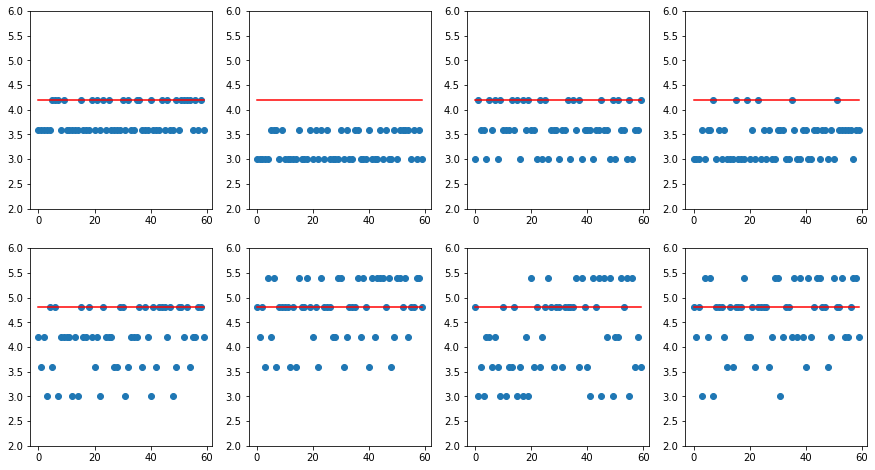

In [5]:
import matplotlib.pyplot as plt
TIMESLOT_SIZE = 0.6
f, axes = plt.subplots(2,4)
f.set_size_inches((15,8))
plt.setp(axes, ylim = (2,6))


d1=[7*TIMESLOT_SIZE for _ in range(len(x[0]))]
d2=[8*TIMESLOT_SIZE for _ in range(len(x[0]))]
for i in range(2):
    for j in range(4):
#         plt.ylim(0,5)
        axes[i][j].scatter(range(len(x[(i*4)+j])), x[(i*4)+j])
        if i==0:
            axes[i][j].plot(range(len(x[i+j])), d1, c='red')
        else:
            axes[i][j].plot(range(len(x[i+j])), d2, c='red')
plt.show()
# plt.savefig('etdelay.png' ,dpi = 500)

#DDQN SP WRR1:1 WRR3:1

In [6]:
import collections

ddq1=collections.Counter(x[0])
ddq2=collections.Counter(x[4])
sp1=collections.Counter(x[1])
sp2=collections.Counter(x[5])
wrr1=collections.Counter(x[2])
wrr2=collections.Counter(x[6])
wrr31=collections.Counter(x[3])
wrr32=collections.Counter(x[7])
print("DDQN E2E delay:",ddq1,ddq2)
print("SP E2E delay:",sp1,sp2)
print("WRR1:1 E2E delay:",wrr1,wrr2)
print("WRR3:1 E2E delay:",wrr31,wrr32)

DDQN E2E delay: Counter({3.6: 37, 4.2: 23}) Counter({4.2: 23, 4.8: 19, 3.6: 10, 3.0: 8})
SP E2E delay: Counter({3.0: 37, 3.6: 23}) Counter({4.8: 23, 5.4: 19, 4.2: 10, 3.6: 8})
WRR1:1 E2E delay: Counter({3.6: 27, 4.2: 18, 3.0: 15}) Counter({4.8: 15, 3.6: 14, 3.0: 11, 5.4: 11, 4.2: 9})
WRR3:1 E2E delay: Counter({3.0: 28, 3.6: 26, 4.2: 6}) Counter({4.8: 22, 4.2: 15, 5.4: 14, 3.6: 6, 3.0: 3})


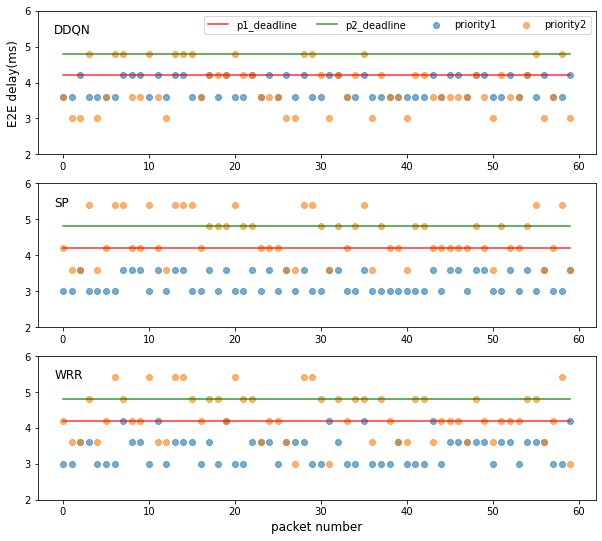

In [21]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(3,1)
f.set_size_inches((10,9))
plt.setp(axes, ylim = (2,6))

TIMESLOT_SIZE = 0.6
d1=[7*TIMESLOT_SIZE for _ in range(len(x[0]))]
d2=[8*TIMESLOT_SIZE for _ in range(len(x[0]))]
tt=['DDQN', 'SP', 'WRR']
for j in range(3):
    axes[j].set_title(tt[j],fontsize=12, loc='left', x=0.03, y=0.8)
    plt.xlabel('packet number', fontsize = 12)
    axes[0].set_ylabel('E2E delay(ms)', fontsize = 12)
    axes[j].scatter(range(len(x[j])), x[j],  alpha = .6, label = 'priority1')
    axes[j].scatter(range(len(x[j+3])), x[j+3],  alpha = .6, label = 'priority2')
#     axes[j].plot(range(len(x[j])), d, c='red', label='deadline')
#     if i==0:
    axes[j].plot(range(len(x[j])), d1, c='red', label = 'p1_deadline', alpha = .8)
#     else:
    axes[j].plot(range(len(x[j])), d2, c='green', label='p2_deadline', alpha = .8)
    axes[0].legend(ncol=4)
# plt.savefig('etdelay.png' ,dpi = 500)    
plt.show()


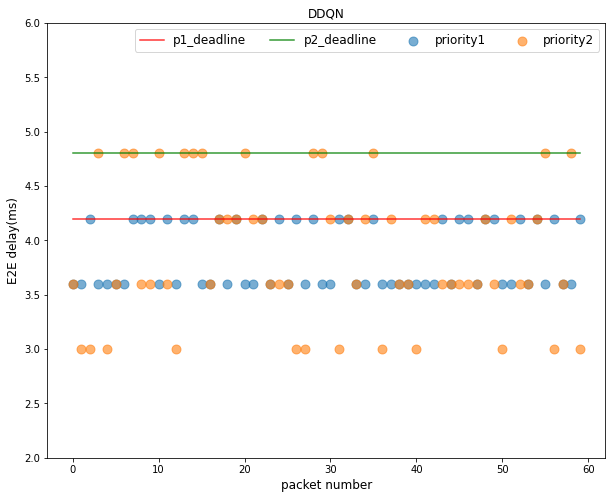

In [22]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(1,1)
f.set_size_inches((10,8))
plt.setp(axes, ylim = (2,6))

TIMESLOT_SIZE = 0.6
d1=[7*TIMESLOT_SIZE for _ in range(len(x[0]))]
d2=[8*TIMESLOT_SIZE for _ in range(len(x[0]))]
axes.set_title('DDQN',fontsize=12)
plt.xlabel('packet number', fontsize = 12)
axes.set_ylabel('E2E delay(ms)', fontsize = 12)
axes.scatter(range(len(x[0])), x[0],  alpha = .6, s=80, label = 'priority1')
axes.scatter(range(len(x[3])), x[3],  alpha = .6, s=80, label = 'priority2')
#     axes[j].plot(range(len(x[j])), d, c='red', label='deadline')
#     if i==0:
axes.plot(range(len(x[0])), d1, c='red', label = 'p1_deadline', alpha = .8)
#     else:
axes.plot(range(len(x[0])), d2, c='green', label='p2_deadline', alpha = .8)
axes.legend(ncol=4, fontsize = 12)
    
# tt=['DDQN', 'SP', 'WRR']
# for j in range(3):
#     axes[j].set_title(tt[j],fontsize=12, loc='left', x=0.03, y=0.8)
#     plt.xlabel('packet number', fontsize = 12)
#     axes[0].set_ylabel('E2E delay(ms)', fontsize = 12)
#     axes[j].scatter(range(len(x[j])), x[j],  alpha = .6, label = 'priority1')
#     axes[j].scatter(range(len(x[j+3])), x[j+3],  alpha = .6, label = 'priority2')
# #     axes[j].plot(range(len(x[j])), d, c='red', label='deadline')
# #     if i==0:
#     axes[j].plot(range(len(x[j])), d1, c='red', label = 'p1_deadline', alpha = .8)
# #     else:
#     axes[j].plot(range(len(x[j])), d2, c='green', label='p2_deadline', alpha = .8)
#     axes[0].legend(ncol=4)
# plt.savefig('etdelay.png' ,dpi = 500)    
plt.savefig('meshdelayddqn.png' ,dpi = 500)    

plt.show()


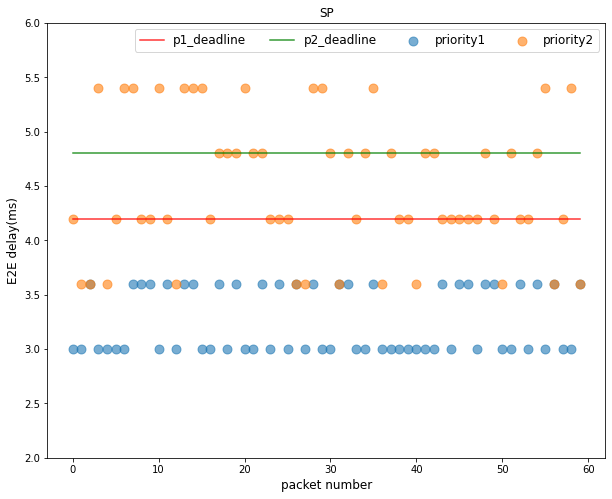

In [23]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(1,1)
f.set_size_inches((10,8))
plt.setp(axes, ylim = (2,6))

TIMESLOT_SIZE = 0.6
d1=[7*TIMESLOT_SIZE for _ in range(len(x[0]))]
d2=[8*TIMESLOT_SIZE for _ in range(len(x[0]))]
axes.set_title('SP',fontsize=12)
plt.xlabel('packet number', fontsize = 12)
axes.set_ylabel('E2E delay(ms)', fontsize = 12)
axes.scatter(range(len(x[1])), x[1],  alpha = .6, s=80, label = 'priority1')
axes.scatter(range(len(x[4])), x[4],  alpha = .6, s=80, label = 'priority2')
#     axes[j].plot(range(len(x[j])), d, c='red', label='deadline')
#     if i==0:
axes.plot(range(len(x[0])), d1, c='red', label = 'p1_deadline', alpha = .8)
#     else:
axes.plot(range(len(x[0])), d2, c='green', label='p2_deadline', alpha = .8)
axes.legend(ncol=4, fontsize = 12)
    
# tt=['DDQN', 'SP', 'WRR']
# for j in range(3):
#     axes[j].set_title(tt[j],fontsize=12, loc='left', x=0.03, y=0.8)
#     plt.xlabel('packet number', fontsize = 12)
#     axes[0].set_ylabel('E2E delay(ms)', fontsize = 12)
#     axes[j].scatter(range(len(x[j])), x[j],  alpha = .6, label = 'priority1')
#     axes[j].scatter(range(len(x[j+3])), x[j+3],  alpha = .6, label = 'priority2')
# #     axes[j].plot(range(len(x[j])), d, c='red', label='deadline')
# #     if i==0:
#     axes[j].plot(range(len(x[j])), d1, c='red', label = 'p1_deadline', alpha = .8)
# #     else:
#     axes[j].plot(range(len(x[j])), d2, c='green', label='p2_deadline', alpha = .8)
#     axes[0].legend(ncol=4)
# plt.savefig('etdelay.png' ,dpi = 500) 
plt.savefig('meshdelaysp.png' ,dpi = 500)    
plt.show()


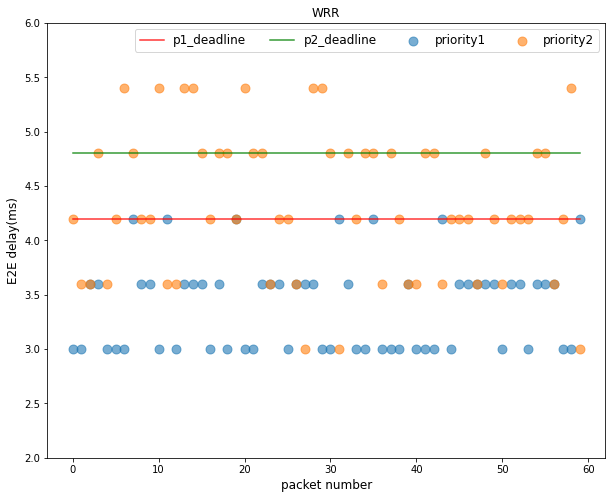

In [25]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(1,1)
f.set_size_inches((10,8))
plt.setp(axes, ylim = (2,6))

TIMESLOT_SIZE = 0.6
d1=[7*TIMESLOT_SIZE for _ in range(len(x[0]))]
d2=[8*TIMESLOT_SIZE for _ in range(len(x[0]))]
axes.set_title('WRR',fontsize=12)
plt.xlabel('packet number', fontsize = 12)
axes.set_ylabel('E2E delay(ms)', fontsize = 12)
axes.scatter(range(len(x[2])), x[2],  alpha = .6, s=80, label = 'priority1')
axes.scatter(range(len(x[5])), x[5],  alpha = .6, s=80, label = 'priority2')
#     axes[j].plot(range(len(x[j])), d, c='red', label='deadline')
#     if i==0:
axes.plot(range(len(x[0])), d1, c='red', label = 'p1_deadline', alpha = .8)
#     else:
axes.plot(range(len(x[0])), d2, c='green', label='p2_deadline', alpha = .8)
axes.legend(ncol=4, fontsize = 12)
    
# tt=['DDQN', 'SP', 'WRR']
# for j in range(3):
#     axes[j].set_title(tt[j],fontsize=12, loc='left', x=0.03, y=0.8)
#     plt.xlabel('packet number', fontsize = 12)
#     axes[0].set_ylabel('E2E delay(ms)', fontsize = 12)
#     axes[j].scatter(range(len(x[j])), x[j],  alpha = .6, label = 'priority1')
#     axes[j].scatter(range(len(x[j+3])), x[j+3],  alpha = .6, label = 'priority2')
# #     axes[j].plot(range(len(x[j])), d, c='red', label='deadline')
# #     if i==0:
#     axes[j].plot(range(len(x[j])), d1, c='red', label = 'p1_deadline', alpha = .8)
# #     else:
#     axes[j].plot(range(len(x[j])), d2, c='green', label='p2_deadline', alpha = .8)
#     axes[0].legend(ncol=4)
plt.savefig('meshdelaywrr.png' ,dpi = 500)    
plt.show()


In [22]:
def oper(ls):
    ls = list(map(lambda x:round(x*0.6,1), ls))
    return ls

In [23]:
def dictsort(rng, counter):
    dct = dict(counter)
    
    for r in rng:
        if not r in dct:
            dct.update({r:0})
        
    d = dict(sorted(dct.items()))
    key = list(d.keys())
    value = list(d.values())
    
    return key, value

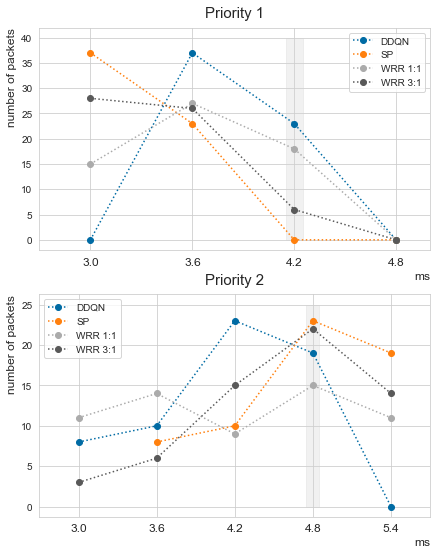

In [34]:
## import matplotlib.pyplot as plt
rang = oper([5,6,7,8])
ran = oper([6,7,8,9])
import seaborn as sns


_DDQN1=dictsort(rang,ddq1)
_DDQN2=dictsort(ran,ddq2)
_SP1=dictsort(rang,sp1)
_SP2=dictsort(ran,sp2)
_WRR1=dictsort(rang,wrr1)
_WRR31=dictsort(rang,wrr31)
_WRR2=dictsort(ran,wrr2)
_WRR32=dictsort(ran,wrr32)

f, axes = plt.subplots(2,1)
f.set_size_inches((7,9))
# plt.setp(axes, ylim = (2,6))
# plt.style.use('default')
sns.set_style('whitegrid')
plt.style.use('tableau-colorblind10')

axes[0].set_xlim((2.7,5))
axes[0].set_title('Priority 1',fontsize=15,pad=10)
axes[0].set_xlabel('ms', fontsize = 12, loc='right')
axes[0].set_ylabel('number of packets', fontsize = 12, loc='top')
axes[0].set_xticks(_DDQN1[0])
axes[0].tick_params(axis='x',labelsize=12)

axes[0].plot(_DDQN1[0],_DDQN1[1],marker='o',linestyle=':')
axes[0].plot(_SP1[0],_SP1[1],marker='o',linestyle=':')
axes[0].plot(_WRR1[0],_WRR1[1],marker='o',linestyle=':')
axes[0].plot(_WRR31[0],_WRR31[1],marker='o',linestyle=':')
axes[0].legend(['DDQN','SP','WRR 1:1','WRR 3:1'])
axes[0].fill([4.15,4.15,4.25,4.25], [40, 0, 0, 40], color='lightgray', alpha=0.3)
# axes[0].text(4.05, 18, 'deadline', fontsize = 14)


axes[1].set_xlim((2.7,5.7))
axes[1].set_title('Priority 2',fontsize=15,pad=10)
axes[1].set_xlabel('ms', fontsize = 12, loc='right')
axes[1].set_ylabel('number of packets', fontsize = 12, loc='top')
axes[1].set_xticks(_DDQN2[0])
axes[1].tick_params(axis='x',labelsize=12)

axes[1].plot(_DDQN2[0],_DDQN2[1],marker='o',linestyle=':')
axes[1].plot(_SP2[0],_SP2[1],marker='o',linestyle=':')
axes[1].plot(_WRR2[0],_WRR2[1],marker='o',linestyle=':')
axes[1].plot(_WRR32[0],_WRR32[1],marker='o',linestyle=':')
axes[1].legend(['DDQN','SP','WRR 1:1','WRR 3:1'])
axes[1].fill([4.75,4.75,4.85,4.85], [25, 0, 0, 25], color='lightgray', alpha=0.3)


# d=[7*0.6 for _ in range(len(x[0]))]

# for i in range(2):
#     for j in range(4):
# #         plt.ylim(0,5)
#         axes[i][j].scatter(range(len(x[(i*4)+j])), oper(x[(i*4)+j]))
#         axes[i][j].plot(range(len(x[i+j])), d, c='red')
# plt.style.use(st[2])

plt.savefig('e2edelay.png' ,dpi = 500)

plt.show()

#DDQN, SP, WRR(1:1), WRR(3:1) 순서

## Weighted round-robin to find optimal weight

## default

In [37]:
#weight 3:1
RRW = 3
WITH_FLOW = False
W = [0.6, 0.5]
CC_DEADLINE = 7
BE_DEADLINE = 8
PERIOD_CC = 2
PERIOD_BE = 2
# MAXSLOTS = 1000
WEIGHT_FILE = '@g513_0214_2_best/@[10835]0.002623665379360318.h5'

sim = GateControlTestSimulation()
result=sim.simulation()


reset
SP , Final Step: 350, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.3000000000000003, 4.490000000000001]
qdelay :  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
RR , Final Step: 350, success: [60, 50, 0, 0, 0, 0, 50, 60], avg_qdelay: [3.4499999999999997, 4.34]
qdelay :  [[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0

In [62]:
#weight 2:1
RRW = 2
WITH_FLOW = False
W = [0.6, 0.5]
CC_DEADLINE = 7
BE_DEADLINE = 8
PERIOD_CC = 2
PERIOD_BE = 2
# MAXSLOTS = 1000
WEIGHT_FILE = '@g513_0214_2_best/@[10835]0.002623665379360318.h5'

sim = GateControlTestSimulation()
result=sim.simulation()

SP , Final Step: 1000, success: [60, 14, 0, 0, 0, 0, 14, 60], avg_qdelay: [3.290000000000001, 5.689999999999999]
RR , Final Step: 1000, success: [60, 54, 0, 0, 0, 0, 54, 60], avg_qdelay: [3.49, 4.369999999999999]
DDQN+H , Final Step: 1000, success: [60, 60, 0, 0, 0, 0, 60, 60], avg_qdelay: [3.890000000000001, 3.97]
reset
SP , Final Step: 1000, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.2800000000000007, 4.489999999999999]
RR , Final Step: 1000, success: [60, 55, 0, 0, 0, 0, 55, 60], avg_qdelay: [3.48, 4.289999999999999]
DDQN+H , Final Step: 1000, success: [60, 60, 0, 0, 0, 0, 60, 60], avg_qdelay: [3.880000000000001, 3.8900000000000006]
reset


In [44]:
#weight 1:1
RRW = 1

WITH_FLOW = False
W = [0.6, 0.5]
CC_DEADLINE = 7
BE_DEADLINE = 8
PERIOD_CC = 2
PERIOD_BE = 2
# MAXSLOTS = 1000
WEIGHT_FILE = '@g513_0214_2_best/@[10835]0.002623665379360318.h5'

sim = GateControlTestSimulation()
result=sim.simulation()

reset
SP , Final Step: 350, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.390000000000001, 4.45]
qdelay :  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
RR , Final Step: 350, success: [60, 57, 0, 0, 0, 0, 57, 60], avg_qdelay: [3.69, 4.15]
qdelay :  [[0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,

In [64]:
#weight 4:1
RRW = 4

WITH_FLOW = False
W = [0.6, 0.5]
CC_DEADLINE = 7
BE_DEADLINE = 8
PERIOD_CC = 2
PERIOD_BE = 2
# MAXSLOTS = 1000
WEIGHT_FILE = '@g513_0214_2_best/@[10835]0.002623665379360318.h5'

sim = GateControlTestSimulation()
result=sim.simulation()

SP , Final Step: 1000, success: [60, 15, 0, 0, 0, 0, 15, 60], avg_qdelay: [3.22, 5.659999999999999]
RR , Final Step: 1000, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.3400000000000003, 4.42]
DDQN+H , Final Step: 1000, success: [60, 60, 0, 0, 0, 0, 60, 60], avg_qdelay: [3.8200000000000003, 3.9399999999999995]
reset
SP , Final Step: 1000, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.31, 4.489999999999999]
RR , Final Step: 1000, success: [60, 51, 0, 0, 0, 0, 51, 60], avg_qdelay: [3.4300000000000006, 4.37]
DDQN+H , Final Step: 1000, success: [60, 60, 0, 0, 0, 0, 60, 60], avg_qdelay: [3.910000000000001, 3.89]
reset


## higher utilization

In [11]:
result_folder = [s for s in os.listdir() if s[0]=='@']


In [18]:
#period 1:5 , weight 3:1
RRW = 3


WITH_FLOW = False
W = [0.6, 0.5]
CC_DEADLINE = 8
BE_DEADLINE = 9
PERIOD_CC = 1
PERIOD_BE = 5
# MAXSLOTS = 1000
WEIGHT_FILE = '@g513_0214_2_best/@[10835]0.002623665379360318.h5'
for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

reset
SP , Final Step: 350, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.310000000000001, 8.669999999999998]
RR , Final Step: 350, success: [15, 55, 0, 0, 0, 0, 55, 15], avg_qdelay: [7.659999999999998, 4.319999999999999]
DDQN+H , Final Step: 350, success: [13, 50, 0, 0, 0, 0, 50, 13], avg_qdelay: [6.58, 5.260000000000001]
reset
*****@[17279]0.0012507716892287135.h5
reset
SP , Final Step: 350, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.2899999999999996, 8.680000000000001]
RR , Final Step: 350, success: [13, 52, 0, 0, 0, 0, 52, 13], avg_qdelay: [7.640000000000001, 4.33]
DDQN+H , Final Step: 350, success: [11, 50, 0, 0, 0, 0, 50, 11], avg_qdelay: [6.6, 5.23]
reset
*****@[17259]0.0013820650056004524.h5
reset
SP , Final Step: 350, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.3200000000000003, 8.59]
RR , Final Step: 350, success: [14, 55, 0, 0, 0, 0, 55, 14], avg_qdelay: [7.670000000000001, 4.239999999999999]
DDQN+H , Final Step: 350, success: [20, 46, 0, 0, 0, 0

In [15]:
#period 1:5 , weight 10:1
RRW = 10

WITH_FLOW = False
W = [0.6, 0.5]
CC_DEADLINE = 8
BE_DEADLINE = 9
PERIOD_CC = 1
PERIOD_BE = 5
# MAXSLOTS = 1000
WEIGHT_FILE = '@g513_0214_2_best/@[10835]0.002623665379360318.h5'
for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

reset
SP , Final Step: 350, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.32, 8.71]
qdelay :  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [60, 60, 56, 56, 52, 52, 48, 48, 44, 44, 40, 40, 36, 36, 32, 32, 28, 28, 24, 24, 20, 20, 16, 16, 12, 12, 8, 8, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
RR , Final Step: 350, success: [33, 46, 0, 0, 0, 0, 46, 33], avg_qdelay: [4.82, 7.21]
qdelay :  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

KeyboardInterrupt: 

In [70]:
#period 1:5 , weight 15:1
RRW = 15

WITH_FLOW = False
W = [0.6, 0.5]
CC_DEADLINE = 8
BE_DEADLINE = 9
PERIOD_CC = 1
PERIOD_BE = 5
# MAXSLOTS = 1000
# WEIGHT_FILE = '@g513_0214_2_best/@[10835]0.002623665379360318.h5'

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

SP , Final Step: 1000, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.3300000000000005, 8.719999999999999]
RR , Final Step: 1000, success: [51, 45, 0, 0, 0, 0, 45, 51], avg_qdelay: [4.23, 7.87]
DDQN+H , Final Step: 1000, success: [11, 49, 0, 0, 0, 0, 49, 11], avg_qdelay: [6.61, 5.349999999999999]
reset
SP , Final Step: 1000, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.2700000000000005, 8.51]
RR , Final Step: 1000, success: [55, 46, 0, 0, 0, 0, 46, 55], avg_qdelay: [4.17, 7.609999999999999]
DDQN+H , Final Step: 1000, success: [14, 50, 0, 0, 0, 0, 50, 14], avg_qdelay: [6.56, 5.22]
reset
*****@[17279]0.0012507716892287135.h5
SP , Final Step: 1000, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.3600000000000003, 8.73]
RR , Final Step: 1000, success: [52, 45, 0, 0, 0, 0, 45, 52], avg_qdelay: [4.26, 7.879999999999999]
DDQN+H , Final Step: 1000, success: [10, 49, 0, 0, 0, 0, 49, 10], avg_qdelay: [6.66, 5.340000000000001]
reset
SP , Final Step: 1000, success: [60, 46, 0

In [74]:
#period 1:5 , weight 20:1
RRW = 20

WITH_FLOW = False
W = [0.6, 0.5]
CC_DEADLINE = 8
BE_DEADLINE = 9
PERIOD_CC = 1
PERIOD_BE = 5
# MAXSLOTS = 1000
# WEIGHT_FILE = '@g513_0214_2_best/@[10835]0.002623665379360318.h5'


for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

SP , Final Step: 1000, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.32, 8.52]
RR , Final Step: 1000, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.92, 7.969999999999999]
DDQN+H , Final Step: 1000, success: [11, 50, 0, 0, 0, 0, 50, 11], avg_qdelay: [6.63, 5.12]
reset
SP , Final Step: 1000, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.3300000000000005, 8.549999999999999]
RR , Final Step: 1000, success: [60, 46, 0, 0, 0, 0, 46, 60], avg_qdelay: [3.93, 7.949999999999999]
DDQN+H , Final Step: 1000, success: [12, 50, 0, 0, 0, 0, 50, 12], avg_qdelay: [6.609999999999999, 5.269999999999999]
reset
*****@[17279]0.0012507716892287135.h5
SP , Final Step: 1000, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.33, 8.74]
RR , Final Step: 1000, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.93, 8.19]
DDQN+H , Final Step: 1000, success: [11, 49, 0, 0, 0, 0, 49, 11], avg_qdelay: [6.63, 5.35]
reset
SP , Final Step: 1000, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdel

In [11]:
RRW = 10

WITH_FLOW = False
W = [0.6, 0.5]
CC_DEADLINE = 8
BE_DEADLINE = 9
PERIOD_CC = 1
PERIOD_BE = 5
# MAXSLOTS = 1000
# WEIGHT_FILE = '@g513_0214_2_best/@[10835]0.002623665379360318.h5'
result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)

reset
SP , Final Step: 350, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.37, 8.629999999999997]
RR , Final Step: 350, success: [33, 45, 0, 0, 0, 0, 45, 33], avg_qdelay: [4.870000000000001, 7.129999999999998]
DDQN+H , Final Step: 350, success: [11, 50, 0, 0, 0, 0, 50, 11], avg_qdelay: [6.65, 5.209999999999999]
reset
*****@[17279]0.0012507716892287135.h5
reset
SP , Final Step: 350, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.340000000000001, 8.639999999999999]
RR , Final Step: 350, success: [32, 45, 0, 0, 0, 0, 45, 32], avg_qdelay: [4.839999999999999, 7.139999999999998]
DDQN+H , Final Step: 350, success: [10, 49, 0, 0, 0, 0, 49, 10], avg_qdelay: [6.63, 5.21]
reset
*****@[17259]0.0013820650056004524.h5
reset
SP , Final Step: 350, success: [60, 45, 0, 0, 0, 0, 45, 60], avg_qdelay: [3.32, 8.719999999999999]
RR , Final Step: 350, success: [34, 45, 0, 0, 0, 0, 45, 34], avg_qdelay: [4.82, 7.219999999999999]
DDQN+H , Final Step: 350, success: [18, 48, 0, 0, 0, 0, 48, 18], avg